In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.9 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Mounted at /content/drive
Using device: cuda


In [3]:
train_data = pd.read_csv('/content/drive/MyDrive/datasets/subtask_2/en/train.tsv',sep='\t')
train_data = train_data.reset_index(drop=True)
print(train_data.head())

      id                                               text label
0   6239  It was not until many years later that it coul...     A
1   9255  Users can then pin these images to their profi...     F
2   1674  The best songs are those that I can sing along...     B
3   5001  I found this book to be poorly written. It was...     D
4  20779  Regulates the application of the EU tariff quo...     E


In [4]:
from sklearn.model_selection import train_test_split
train_data_texts = train_data['text'].to_list()
train_data_labels = train_data['label'].to_list()
train_texts, test_texts, train_labels, test_labels = train_test_split(train_data_texts, train_data_labels, test_size=0.1)
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.1)
print('train data size: ', len(train_texts))
print('validation data size: ', len(val_texts))
print('test data size: ', len(test_texts))


train data size:  18156
validation data size:  2018
test data size:  2242


In [5]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("t5-base")
model = AutoModelForSeq2SeqLM.from_pretrained("t5-base")

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [6]:
def generate_paraphrase(text):
    input_ids = tokenizer.encode(text, return_tensors="pt")
    outputs = model.generate(input_ids, num_beams=10, max_length=500, early_stopping=True, repetition_penalty=2.5, length_penalty=1.0)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [7]:
#paraphrasing train_texts
from tqdm import tqdm
paraphrased_train_texts = []
for text in tqdm(train_texts[:100]):
    paraphrased_train_texts.append(generate_paraphrase(text))

#print 10 paraphrased texts
for i in range(10):
    print("\n")
    print(train_texts[i])
    print(paraphrased_train_texts[i])
    print("---------------------------")
    print("\n")

100%|██████████| 100/100 [18:42<00:00, 11.23s/it]



The story was disjointed, the characters were cliche, and the pacing was terrible. I found myself skimming pages, hoping to find something of substance, but I was sorely disappointed. Overall, I wouldnt recommend this book.
The story was disjointed, the characters were cliche, and the pacing was terrible.
---------------------------




This is where you can insert your hose. Inserting the hose into the pipe should be easy, but if its difficult to get in, try pushing up on the lower part of the pipe with your thumb or finger. If all else fails, you may have an obstruction that needs to be removed before you can flush the toilet. These are common problems:. A clogged drain usually doesnt require a plumber to come out and do anything. You can remove the clog by using some household
the pipe. the hose into the pipe. If its difficult to get in, try pushing up on the lower part of the pipe with your thumb or finger. A clogged drain usually doesnt require a plumber to come out and do anyth

In [8]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

# Load language model and tokenizer
model_name = 'gpt2' # or any other causal LM model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Define function to calculate log probability of a sentence
def calculate_log_prob(sentence):
    input_ids = tokenizer.encode(sentence, return_tensors='pt')
    with torch.no_grad():
        logits = model(input_ids).logits
    log_prob = 0.0
    for i in range(1, input_ids.shape[1]):
        log_prob += logits[0, i-1, input_ids[0, i]].item()
    return log_prob


In [9]:
#calculate for train_texts
from tqdm import tqdm
train_log_probs = []
para_train_log_probs = []
for text in tqdm(train_texts[:100]):
    train_log_probs.append(calculate_log_prob(text))
for text in tqdm(paraphrased_train_texts):
    para_train_log_probs.append(calculate_log_prob(text))

100%|██████████| 100/100 [00:31<00:00,  3.19it/s]


In [10]:
train_data = pd.DataFrame({'text':train_texts[:100], 'label':train_labels[:100], 'log_prob':train_log_probs, 'para_log_prob':para_train_log_probs})
print(train_data.head(10))


                                                text label      log_prob  \
0  The story was disjointed, the characters were ...     F  -4807.294774   
1  This is where you can insert your hose. Insert...     B -10027.656666   
2  It is a fundamental principle of public intern...     E  -7788.525149   
3  (c) For the purposes of this Part, the followi...     D  -7494.585943   
4  omg i went to the store today and found out th...     C  -2249.461826   
5  hog weighs about 300 lbs. When you have your h...     B  -9712.477452   
6  I use the pizza stone and no oven necessary. I...     E  -7500.962880   
7  Gently press inwards and use your thumb to lif...     F  -3222.704273   
8  having the best saturday..BBQ, amazing food an...     A  -2084.878333   
9  The event features a range of activities inclu...     C  -9971.938924   

   para_log_prob  
0   -1471.840401  
1   -4544.034270  
2   -7549.332110  
3   -6249.381019  
4   -2009.366898  
5   -1885.487147  
6   -6722.751471  
7    -814.6

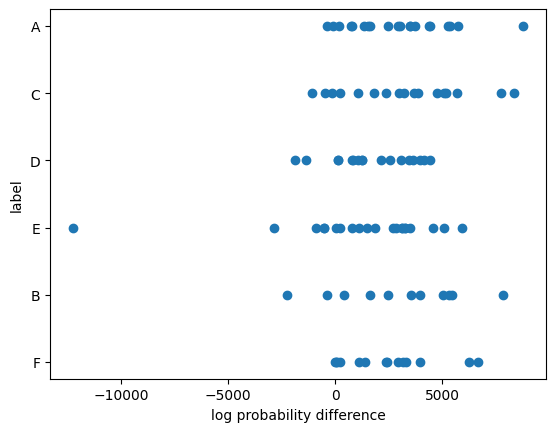

In [11]:
#calculate difference in log probability
train_data['diff_log_prob'] = train_data['para_log_prob'] - train_data['log_prob']

#plot the log probability difference scores with label
plt.scatter(train_data['diff_log_prob'], train_data['label'])
plt.xlabel('log probability difference')
plt.ylabel('label')
plt.show()